In [1]:
import numpy as np
import pandas as pd

In [2]:
# Загружаем и обрабатываем данные заново, т.е. строим универсальный pipeline с обработчиками
# 1. Загрузка данных
df = pd.read_csv('abalone.csv')

df['Age'] = df['Rings'] + 1.5 # Перейдем на возраст вместо колец

# 2. Определяем признаки, все вместе
X_full = df.drop(columns=['Age', 'Rings'])
y = df['Age']

In [3]:
numeric_features = X_full.select_dtypes(include=np.number).columns.to_list()
categorical_features = X_full.select_dtypes(exclude=np.number).columns.to_list()
target_column = 'Age'

# 3. Только числовые признаки
X_num = df[numeric_features]

print("Числовые признаки:", numeric_features)
print("Категориальные признаки:", categorical_features)

Числовые признаки: ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
Категориальные признаки: ['Sex']


In [4]:
X_num

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,0.440,0.365,0.125,NaN,0.2155,0.1140,0.1550
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [5]:
y

0       16.5
1        8.5
2       10.5
3       11.5
4        8.5
        ... 
4172    12.5
4173    11.5
4174    10.5
4175    11.5
4176    13.5
Name: Age, Length: 4177, dtype: float64

1. Построение моделей на числовых признаках (минимум - NB и kNN, максимум - любые) с параметрами по умолчанию, вычисление метрик + комментарий о качестве моделей

Модели: простая линейная регрессия + с регуляризацией (Ridge), Байесовская линейная регрессия (Naive Bayes), kNN, случайный лес и классический градиентный бустинг

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [7]:
from sklearn.model_selection import train_test_split
# 4. Разделяем выборку (только числовые)
X_train_num, X_test_num, y_train, y_test = train_test_split(X_num, y, test_size=0.25, random_state=42)

In [8]:
# Препроцессор: заполнение медианой (т.к. в EDA обнаружили выбросы и медиана наиболее устойчива) + нормализация
# 5. Препроцессор ТОЛЬКО для числовых признаков
preprocessor_num = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features)
    ])


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# 6. Метрики
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Модель: {name}")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}\n")
    return {"MAE": mae, "RMSE": rmse, "R²": r2}

In [10]:
# 7. Модели (только числовые)
models_num = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'BayesianRidge': BayesianRidge(),
    'kNN': KNeighborsRegressor(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGB': XGBRegressor(random_state=42)
}

In [11]:
# 8. Обучение моделей только на числовых признаках
results_num = {}

for name, model in models_num.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor_num), ('model', model)])
    pipe.fit(X_train_num, y_train)
    y_pred = pipe.predict(X_test_num)
    metrics = evaluate_model(y_test, y_pred, name)
    results_num[name] = metrics

Модель: Linear
MAE: 1.6651, RMSE: 2.2651, R²: 0.5013

Модель: Ridge
MAE: 1.6646, RMSE: 2.2647, R²: 0.5014

Модель: BayesianRidge
MAE: 1.6642, RMSE: 2.2644, R²: 0.5016

Модель: kNN
MAE: 1.6297, RMSE: 2.3074, R²: 0.4825

Модель: RandomForest
MAE: 1.5993, RMSE: 2.2277, R²: 0.5176

Модель: XGB
MAE: 1.6608, RMSE: 2.3266, R²: 0.4738



In [12]:
# 9. Переводим в датафрейм
df_results_num = pd.DataFrame(results_num).T
df_results_num.index.name = 'Model'
df_results_num.reset_index(inplace=True)

print("\nРезультаты на числовых признаках:")
print(df_results_num)


Результаты на числовых признаках:
           Model       MAE      RMSE        R²
0         Linear  1.665108  2.265094  0.501268
1          Ridge  1.664636  2.264732  0.501427
2  BayesianRidge  1.664176  2.264391  0.501577
3            kNN  1.629665  2.307392  0.482467
4   RandomForest  1.599301  2.227711  0.517594
5            XGB  1.660771  2.326592  0.473818


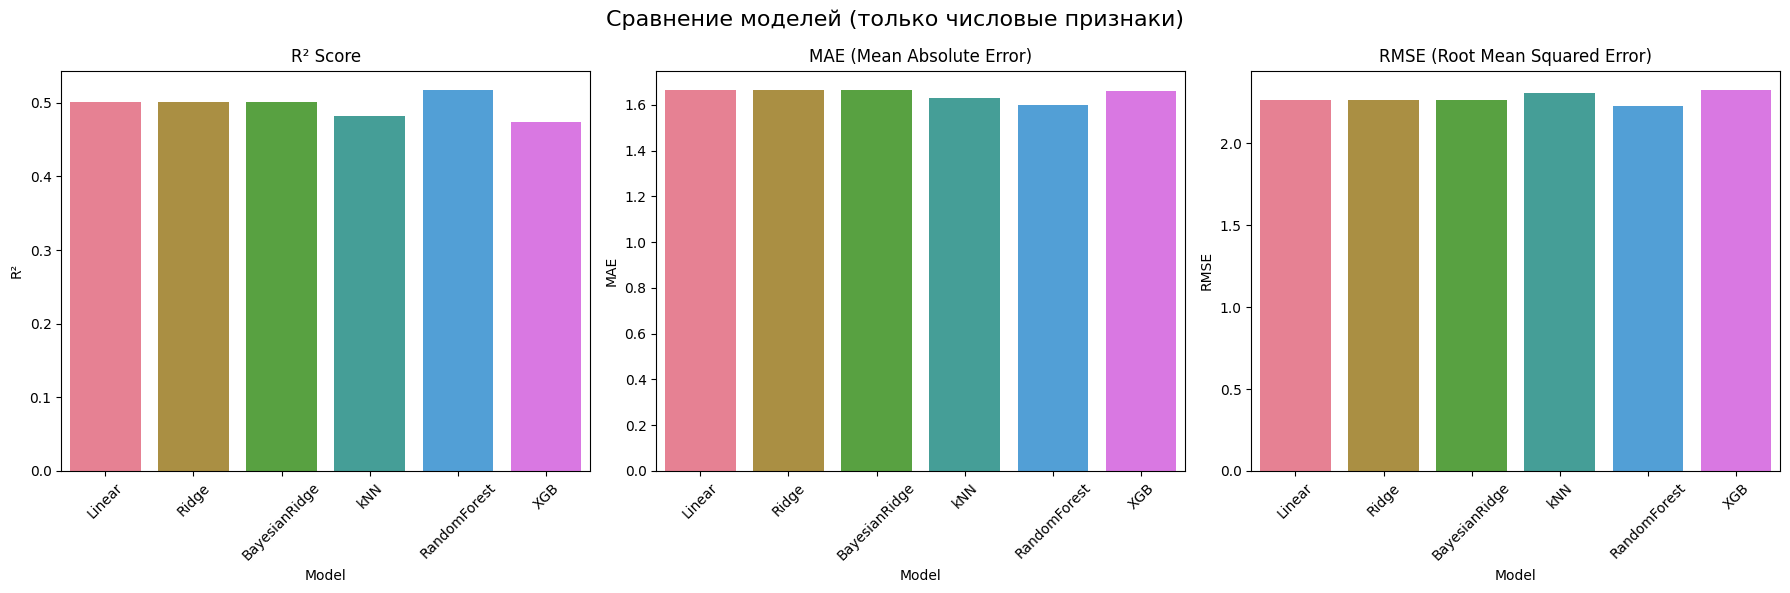

In [13]:
# 10. Визуализация метрик (только числа)
import matplotlib.pyplot as plt
import seaborn as sns

# Цветовая палитра
palette = sns.color_palette("husl", len(df_results_num))

# Настройки графика
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
fig.suptitle('Сравнение моделей (только числовые признаки)', fontsize=16)

# R²
sns.barplot(ax=axes[0], x='Model', y='R²', data=df_results_num, hue='Model', palette=palette, legend=False)
axes[0].set_title('R² Score')
axes[0].tick_params(axis='x', rotation=45)

# MAE
sns.barplot(ax=axes[1], x='Model', y='MAE', data=df_results_num, hue='Model', palette=palette, legend=False)
axes[1].set_title('MAE (Mean Absolute Error)')
axes[1].tick_params(axis='x', rotation=45)

# RMSE
sns.barplot(ax=axes[2], x='Model', y='RMSE', data=df_results_num, hue='Model', palette=palette, legend=False)
axes[2].set_title('RMSE (Root Mean Squared Error)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Мы видим (Чем меньше MAE и RMSE — тем лучше. Чем больше R² — тем лучше):

- Random Forest показывает лучший R² и самый низкий MAE и RMSE
- XGB отстаёт — нужен подбор гиперпараметров
- Linear, Ridge, BayesianRidge почти одинаковы, т.к. разные версии линейной регрессии
- kNN показывает средний результат

Лучшая модель на данном этапе — Random Forest, она даёт минимальную ошибку и максимальный коэффициент детерминации.

In [14]:
# 11. Подбор гиперпараметров (GridSearchCV) - только числа
from sklearn.model_selection import GridSearchCV

param_grids_num = {
    'Linear': {}, # LinearRegression не имеет значимых гиперпараметров для подбора - используем как бейзлайн
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'BayesianRidge': {
        'model__alpha_1': [1e-6, 1e-5],
        'model__alpha_2': [1e-6, 1e-5]
    },
    'kNN': {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    'RandomForest': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'XGB': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    }
}

In [15]:
best_metrics_num = {} # Словарь для хранения лучших метрик

for name, model in models_num.items():
    print(f"{'='*50}\nОбучение модели: {name} (только числа)")
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor_num), ('model', model)])
    # Если у модели есть параметры для подбора
    if name in param_grids_num and len(param_grids_num[name]) > 0:
        gs = GridSearchCV(pipe, param_grids_num[name], scoring='r2', cv=5, n_jobs=-1)
        gs.fit(X_train_num, y_train)
        
        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test_num)
        metrics = evaluate_model(y_test, y_pred, f"{name} (подобранные параметры)")
        best_metrics_num[name] = metrics
    # Просто обучаем без подбора    
    else:
        pipe.fit(X_train_num, y_train)
        y_pred = pipe.predict(X_test_num)
        metrics = evaluate_model(y_test, y_pred, f"{name} (по умолчанию)")
        best_metrics_num[name] = metrics

Обучение модели: Linear (только числа)
Модель: Linear (по умолчанию)
MAE: 1.6651, RMSE: 2.2651, R²: 0.5013

Обучение модели: Ridge (только числа)
Модель: Ridge (подобранные параметры)
MAE: 1.6646, RMSE: 2.2647, R²: 0.5014

Обучение модели: BayesianRidge (только числа)
Модель: BayesianRidge (подобранные параметры)
MAE: 1.6642, RMSE: 2.2644, R²: 0.5016

Обучение модели: kNN (только числа)
Модель: kNN (подобранные параметры)
MAE: 1.5724, RMSE: 2.2305, R²: 0.5164

Обучение модели: RandomForest (только числа)
Модель: RandomForest (подобранные параметры)
MAE: 1.5825, RMSE: 2.2087, R²: 0.5258

Обучение модели: XGB (только числа)
Модель: XGB (подобранные параметры)
MAE: 1.5334, RMSE: 2.1739, R²: 0.5406



In [16]:
# 12. Результаты после подбора (только числа)
df_best_results_num = pd.DataFrame(best_metrics_num).T
df_best_results_num.index.name = 'Model'
df_best_results_num.reset_index(inplace=True)

print("\nЛучшие результаты (только числа):")
print(df_best_results_num)


Лучшие результаты (только числа):
           Model       MAE      RMSE        R²
0         Linear  1.665108  2.265094  0.501268
1          Ridge  1.664636  2.264732  0.501427
2  BayesianRidge  1.664176  2.264391  0.501577
3            kNN  1.572380  2.230529  0.516373
4   RandomForest  1.582547  2.208657  0.525811
5            XGB  1.533410  2.173861  0.540634


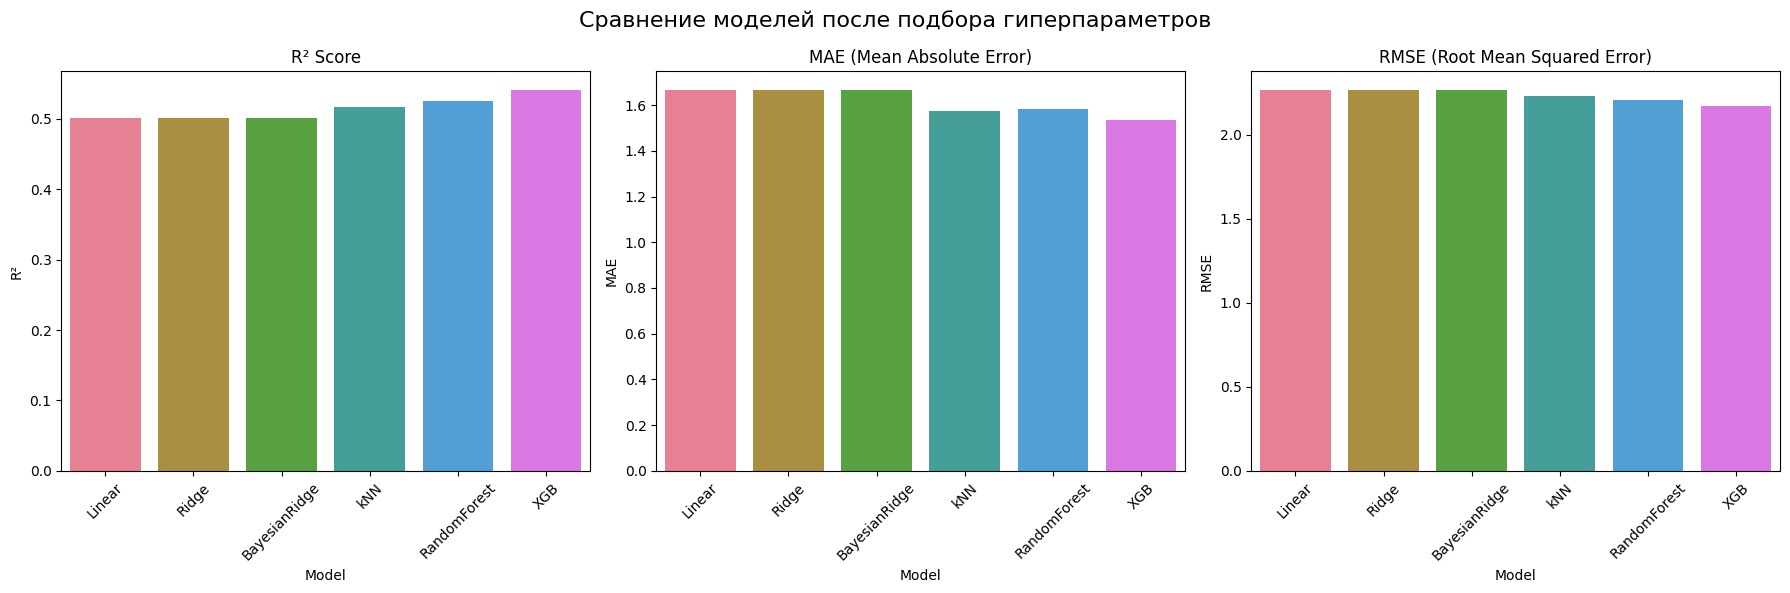

In [17]:
# Визуализация метрик после подбора (только числа)

palette = sns.color_palette("husl", len(df_best_results_num))

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
fig.suptitle('Сравнение моделей после подбора гиперпараметров', fontsize=16)

sns.barplot(ax=axes[0], x='Model', y='R²', data=df_best_results_num, hue='Model', palette=palette, legend=False)
axes[0].set_title('R² Score')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[1], x='Model', y='MAE', data=df_best_results_num, hue='Model', palette=palette, legend=False)
axes[1].set_title('MAE (Mean Absolute Error)')
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[2], x='Model', y='RMSE', data=df_best_results_num, hue='Model', palette=palette, legend=False)
axes[2].set_title('RMSE (Root Mean Squared Error)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Сводная таблица "до" и "после"

In [18]:
# Отключаем экспоненциальную запись
pd.set_option('display.float_format', '{:.6f}'.format)

# Чтобы таблица не переносилась и показывалась целиком
pd.set_option('display.width', 1000)           # ширина окна
pd.set_option('display.max_columns', None)     # показывать все колонки
pd.set_option('display.colheader_justify', 'left')  # заголовки слева

In [19]:
# Добавляем префикс к колонкам
df_before = df_results_num.copy()
df_before.columns = ['Model', 'MAE_before', 'RMSE_before', 'R²_before']

df_after = df_best_results_num.copy()
df_after.columns = ['Model', 'MAE_after', 'RMSE_after', 'R²_after']

# Объединяем
df_comparison = pd.merge(df_before, df_after, on='Model')

# Вычисляем разницу
df_comparison['MAE_diff'] = df_comparison['MAE_before'] - df_comparison['MAE_after']
df_comparison['RMSE_diff'] = df_comparison['RMSE_before'] - df_comparison['RMSE_after']
df_comparison['R²_diff'] = df_comparison['R²_after'] - df_comparison['R²_before']
df_comparison['R²_%'] = df_comparison['R²_after'] * 100 / df_comparison['R²_before']

print("\nСводная таблица: до и после подбора гиперпараметров")
print(df_comparison[['Model', 'MAE_before', 'MAE_after', 'MAE_diff',
                     'RMSE_before', 'RMSE_after', 'RMSE_diff',
                     'R²_before', 'R²_after', 'R²_diff', 'R²_%']])


Сводная таблица: до и после подбора гиперпараметров
  Model           MAE_before  MAE_after  MAE_diff  RMSE_before  RMSE_after  RMSE_diff  R²_before  R²_after  R²_diff   R²_%     
0         Linear 1.665108    1.665108    0.000000 2.265094     2.265094     0.000000  0.501268   0.501268   0.000000 100.000000
1          Ridge 1.664636    1.664636    0.000000 2.264732     2.264732     0.000000  0.501427   0.501427   0.000000 100.000000
2  BayesianRidge 1.664176    1.664176   -0.000000 2.264391     2.264391    -0.000000  0.501577   0.501577  -0.000000 100.000000
3            kNN 1.629665    1.572380    0.057285 2.307392     2.230529     0.076863  0.482467   0.516373   0.033906 107.027540
4   RandomForest 1.599301    1.582547    0.016755 2.227711     2.208657     0.019054  0.517594   0.525811   0.008217 101.587519
5            XGB 1.660771    1.533410    0.127361 2.326592     2.173861     0.152731  0.473818   0.540634   0.066816 114.101519


После подбора гиперпараметров:

- XGBoost показал наибольшее улучшение (+14% по R²), что говорит о его потенциале
- kNN стал точнее (+7% по R²) за счёт оптимальных соседей
- Random Forest также улучшился, но незначительно (+1.5% по R²)
- Линейные модели остались на том же уровне

Подключаем Optuna для поиска гиперпараметров

In [20]:
# 13. Optuna для XGBoost
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }

    model = XGBRegressor(**params)
    pipe = Pipeline(steps=[('preprocessor', preprocessor_num), ('model', model)])
    score = -cross_val_score(pipe, X_train_num, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Лучшие параметры (Optuna):", study.best_params)
print("Лучшая MAE:", study.best_value)

[I 2025-05-07 17:59:44,937] A new study created in memory with name: no-name-0e9ce262-2053-4e48-9f69-5e524a0b3a67
[I 2025-05-07 17:59:45,027] Trial 0 finished with value: 1.6344763791054953 and parameters: {'n_estimators': 104, 'max_depth': 5, 'learning_rate': 0.26058260102588654, 'subsample': 0.796460474170002, 'colsample_bytree': 0.8416653211272336}. Best is trial 0 with value: 1.6344763791054953.
[I 2025-05-07 17:59:45,240] Trial 1 finished with value: 1.6377845463432337 and parameters: {'n_estimators': 51, 'max_depth': 9, 'learning_rate': 0.181476350935479, 'subsample': 0.7953294430401857, 'colsample_bytree': 0.7577713242650692}. Best is trial 0 with value: 1.6344763791054953.
[I 2025-05-07 17:59:45,299] Trial 2 finished with value: 1.5674768415716056 and parameters: {'n_estimators': 59, 'max_depth': 5, 'learning_rate': 0.10995699228370151, 'subsample': 0.9854105140757214, 'colsample_bytree': 0.9090709056964614}. Best is trial 2 with value: 1.5674768415716056.
[I 2025-05-07 17:59:4

Лучшие параметры (Optuna): {'n_estimators': 184, 'max_depth': 5, 'learning_rate': 0.030806229098981043, 'subsample': 0.8391210951310146, 'colsample_bytree': 0.7717608354196355}
Лучшая MAE: 1.5428817037027183


In [21]:
best_xgb_optuna = Pipeline([
    ('preprocessor', preprocessor_num),
    ('model', XGBRegressor(**study.best_params, random_state=42))
])
best_xgb_optuna.fit(X_train_num, y_train)
y_pred_optuna = best_xgb_optuna.predict(X_test_num)
evaluate_model(y_test, y_pred_optuna, "XGB (Optuna)")

Модель: XGB (Optuna)
MAE: 1.5366, RMSE: 2.1625, R²: 0.5454



{'MAE': 1.53656659422879, 'RMSE': 2.162492089023414, 'R²': 0.5454263286435039}

Похоже, что улучшить не удалось. Параметры по умолчанию хорошо работают "из коробки".
| Model          | MAE_after | RMSE_after | R²_after  |
|----------------|-----------|------------|-----------|
| XGB            | 1.533410  | 2.173861   | 0.540634  |
| XGB (Optuna)   | 1.5503    | 2.1735     | 0.5408    |

Теперь следующий шаг.
- Добавление категориальных признаков
- Выбор лучшей модели (XGB) + добавка CatBoost и LightGBM
- Подбор гиперпараметров и проверка - улучшится ли качество модели за счёт новых данных
- Сравнение метрик до/после

In [22]:
# 14. Теперь добавляем категориальные признаки
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [23]:
# 15. Препроцессор с категориями
preprocessor_with_cat = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [24]:
# 16. Модели с категориями - используем варианты бустинга
models_with_cat = {
    'XGB': XGBRegressor(random_state=42),
    'LGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0)
}

param_grids_with_cat = {
    'XGB': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'LGBM': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1],
        'model__num_leaves': [20, 31]
    },
    'CatBoost': {
        'model__iterations': [50, 100],
        'model__learning_rate': [0.01, 0.1],
        'model__depth': [4, 6]
    }
}

In [25]:
best_metrics_with_cat = {}
best_models_with_cat = {}

for name, model in models_with_cat.items():
    print(f"{'='*50}\nОбучение модели: {name} с категориальными признаками")
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor_with_cat), ('model', model)])
    
    if name in param_grids_with_cat and len(param_grids_with_cat[name]) > 0:
        gs = GridSearchCV(pipe, param_grids_with_cat[name], scoring='r2', cv=5, n_jobs=-1)
        gs.fit(X_train_full, y_train)
        
        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test_full)
        metrics = evaluate_model(y_test, y_pred, f"{name} (с категориями)")
        best_metrics_with_cat[name] = metrics
        
    else:
        pipe.fit(X_train_full, y_train)
        y_pred = pipe.predict(X_test_full)
        metrics = evaluate_model(y_test, y_pred, f"{name} (по умолчанию)")
        best_metrics_with_cat[name] = metrics

    best_models_with_cat[name] = best_model  # <-- мы сохраняем лучшую модель сюда

Обучение модели: XGB с категориальными признаками
Модель: XGB (с категориями)
MAE: 1.5486, RMSE: 2.1901, R²: 0.5338

Обучение модели: LGBM с категориальными признаками
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 3132, number of used features: 11
[LightGBM] [Info] Start training from score 11.464879
Модель: LGBM (с категориями)
MAE: 1.5095, RMSE: 2.1541, R²: 0.5489

Обучение модели: CatBoost с категориальными признаками


c:\Programs\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Модель: CatBoost (с категориями)
MAE: 1.5274, RMSE: 2.1558, R²: 0.5482



In [26]:
# 17. Делаем сводную таблицу с категориями
df_best_results_with_cat = pd.DataFrame(best_metrics_with_cat).T
df_best_results_with_cat.index.name = 'Model'
df_best_results_with_cat.reset_index(inplace=True)
df_best_results_with_cat.columns = ['Model', 'MAE_with_cat', 'RMSE_with_cat', 'R²_with_cat']
 
# Берём только XGB из df_best_results_num
df_best_results_num_xgb = df_best_results_num[df_best_results_num['Model'] == 'XGB']

# 18. Соединяем с предыдущими результатами
# Объединяем с df_best_results_with_cat
df_comparison = pd.merge(
    df_best_results_num_xgb,
    df_best_results_with_cat,
    on='Model',
    suffixes=('', '_with_cat')
)

# 19. Вычисляем разницу
df_comparison['MAE_diff'] = df_comparison['MAE'] - df_comparison['MAE_with_cat']
df_comparison['RMSE_diff'] = df_comparison['RMSE'] - df_comparison['RMSE_with_cat']
df_comparison['R²_diff'] = df_comparison['R²_with_cat'] - df_comparison['R²']

# 20. Форматируем вывод
pd.set_option('display.float_format', '{:.6f}'.format)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

print("\nСводная таблица: до/после добавления категориальных признаков")
print(df_comparison[['Model', 'MAE', 'MAE_with_cat', 'MAE_diff',
                     'RMSE', 'RMSE_with_cat', 'RMSE_diff',
                     'R²', 'R²_with_cat', 'R²_diff']])


Сводная таблица: до/после добавления категориальных признаков
  Model  MAE      MAE_with_cat  MAE_diff  RMSE     RMSE_with_cat  RMSE_diff  R²       R²_with_cat  R²_diff 
0  XGB  1.533410 1.548604      -0.015194 2.173861 2.190053       -0.016192  0.540634 0.533766     -0.006868


Получаем странный результат. После добавления категориальных признаков качество XGBoost немного упало : 
- MAE увеличился
- R² уменьшился

In [27]:
# Таблица 1: модели только на числах
print("\nРезультаты на числовых признаках:")
print(df_results_num)

# Таблица 2: модели с категориями
print("\nРезультаты с категориальными признаками:")
print(df_best_results_with_cat)

# Теперь сравниваем только XGB
xgb_only_num = df_best_results_num[df_best_results_num['Model'] == 'XGB']
xgb_only_cat = df_best_results_with_cat[df_best_results_with_cat['Model'] == 'XGB']

if not xgb_only_num.empty and not xgb_only_cat.empty:
    df_comparison = pd.DataFrame({
        'Metric': ['MAE', 'RMSE', 'R²'],
        'Before (numeric only)': [
            xgb_only_num['MAE'].values[0],
            xgb_only_num['RMSE'].values[0],
            xgb_only_num['R²'].values[0]
        ],
        'After (with categories)': [
            xgb_only_cat['MAE_with_cat'].values[0],
            xgb_only_cat['RMSE_with_cat'].values[0],
            xgb_only_cat['R²_with_cat'].values[0]
        ],
        'Difference': [
            xgb_only_num['MAE'].values[0] - xgb_only_cat['MAE_with_cat'].values[0],
            xgb_only_num['RMSE'].values[0] - xgb_only_cat['RMSE_with_cat'].values[0],
            xgb_only_cat['R²_with_cat'].values[0] - xgb_only_num['R²'].values[0]
        ]
    })

    print("\nСводное сравнение XGB до и после добавления категорий:")
    print(df_comparison.to_string(index=False))
else:
    print("Ошибка: не найдены данные для XGB в одной из таблиц.")


Результаты на числовых признаках:
  Model           MAE      RMSE     R²     
0         Linear 1.665108 2.265094 0.501268
1          Ridge 1.664636 2.264732 0.501427
2  BayesianRidge 1.664176 2.264391 0.501577
3            kNN 1.629665 2.307392 0.482467
4   RandomForest 1.599301 2.227711 0.517594
5            XGB 1.660771 2.326592 0.473818

Результаты с категориальными признаками:
  Model      MAE_with_cat  RMSE_with_cat  R²_with_cat
0       XGB 1.548604      2.190053       0.533766    
1      LGBM 1.509517      2.154103       0.548946    
2  CatBoost 1.527365      2.155839       0.548219    

Сводное сравнение XGB до и после добавления категорий:
Metric  Before (numeric only)  After (with categories)  Difference
 MAE   1.533410               1.548604                 -0.015194  
RMSE   2.173861               2.190053                 -0.016192  
  R²   0.540634               0.533766                 -0.006868  


- Категориальный признак 'Sex' не помог XGBoost, он даже усложнил задачу и ухудшил качество модели
- Но для других моделей (LGBM и CatBoost), наоборот, качество улучшилось

Пробуем обучить CatBoost без препроцессора, потому что он сам умеет работать с категориями, но это не помогло улучшить модель, метрики даже упали

In [28]:
from catboost import Pool

# Укажем, какие признаки категориальные
cat_features = X_full.select_dtypes(exclude=np.number).columns.tolist()

train_pool = Pool(X_train_full, y_train, cat_features=cat_features)
test_pool = Pool(X_test_full, y_test, cat_features=cat_features)

model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)
model.fit(train_pool)

y_pred = model.predict(test_pool)
metrics = evaluate_model(y_test, y_pred, "CatBoost (нативно)")

Модель: CatBoost (нативно)
MAE: 1.5301, RMSE: 2.1594, R²: 0.5467



По итогу LGBM показало наилучшие результаты - с ним и двинемся дальше

In [33]:
import shap
from explainerdashboard import RegressionExplainer, ExplainerDashboard

# 1. Берём обученную LGBM-модель из best_models_with_cat
best_lgbm_model = best_models_with_cat['LGBM']

# 2. Получаем предобработчик и сам регрессор
preprocessor = best_lgbm_model.named_steps['preprocessor']
model = best_lgbm_model.named_steps['model']

# 3. Применяем препроцессор к тестовой выборке
X_test_processed = preprocessor.transform(X_test_full)

# 4. Создаём DataFrame с понятными именами признаков после OHE
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(cat_feature_names) + numeric_features

X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

# 5. Создаём SHAP-эксплайнер на основе модели и обработанных данных
shap_explainer = shap.Explainer(model.predict, X_test_processed_df)
shap_values = shap_explainer(X_test_processed_df)

# 6. Создаём RegressionExplainer — без параметра shap_explainer
reg_explainer = RegressionExplainer(
    model,
    X_test_processed_df,
    y_test,
    # SHAP значения передаются напрямую в ExplainerDashboard
)

# 7. Создаём dashboard
db = ExplainerDashboard(reg_explainer, title="LGBM Abalone Age Predictor", shap_mode="regression")

# 8. Сохраняем конфигурацию дашборда
db.to_yaml("abalone_lgbm_dashboard.yaml", explainerfile="lgbm_explainer.joblib", dump_explainer=True)

PermutationExplainer explainer: 1046it [00:54, 19.31it/s]                          

Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..


Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Dumping configuration .yaml to c:\Programs\PythonProjects\EDA_and_dev\eda_and_dev_tool

In [34]:
db.app.run()